<a href="https://colab.research.google.com/github/pepedp/COVID-19/blob/master/Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 ![texto alternativo](https://www.acshoco.org/wp-content/uploads/2020/03/COVID-19.png)

# **INICIO**


In [0]:
#@title INICIO
#LIBRERIRAS 
import pandas as pd
import math
import numpy as np
import math
import matplotlib.pyplot as plt
from google.cloud import bigquery
import scipy.integrate 
%matplotlib inline 
 
#FUNCION PARA DETERMINAR LOS DIAS A PRONOSTICAR  
def dias_predecir(dias):
  from datetime import datetime 
  diferencia=datetime.today()-datetime.strptime(fecha_fin, '%Y-%m-%d')
  diferencia.days
  i=0
  semana=[]
  dia=0
  if (Exponencial):
    dia = dataset.index.get_loc(dataset.last_valid_index()-diferencia.days+1)
    for i in range(0,dias+diferencia.days):
      semana.append(dia+i)    
      i+=i
  else:
    dia = dataset.index.get_loc(dataset.last_valid_index() )
    for i in range(0,dias):
      semana.append(dia+i)    
      i+=i
  return semana
 
#FUNCION VELOCIDAD, ACELERACION E INDICE DE CRECIMIENTO
def vel_crecimiento(horas=24):
  j=0
  velocidad=[]
  aceleracion=[]
  indice_crecimiento=[]
  indice_activos=[]
  fin = dataset.index.get_loc(dataset.last_valid_index())
  if horas>24:
    print("Solicitud no procesada / NO debe ser mayor a 24 Horas")
  else:
    for j in range (0,fin+1):
      if j==0:
        velocidad.append(dataset.iloc[j:j+1, 2].values/(24/horas))
        aceleracion.append((velocidad[j]) )
        indice_crecimiento.append(dataset.iloc[j:j+1, 2].values)
        indice_activos.append(dataset.iloc[j:j+1, 5].values)
        j+=j
      else:    
        velocidad.append((dataset.iloc[j:j+1, 2].values - dataset.iloc[j-1:j, 2].values)/(24/horas))         
        aceleracion.append((velocidad[j]-velocidad[j-1]) )
        indice_crecimiento.append((dataset.iloc[j:j+1, 2].values/dataset.iloc[j-1:j, 2].values)) 
        indice_activos.append((dataset.iloc[j:j+1, 5].values/dataset.iloc[j-1:j, 5].values)) 
        j+=j
    return np.array(velocidad),np.array(aceleracion),np.array(indice_crecimiento), np.array(indice_activos)
 
 
#ECUACIONES DIFERENCIALES
def Modelo_SIR(y,t, N,beta, gamma):            
    S, I, R = y
    
    dS = -beta*S*I/N
    dI = beta*S*I/N - gamma*I 
    dR = gamma*I 
    return ([dS, dI, dR])
 
 
#MODELO EXPONENCIAL
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#https://www.it-swarm.dev/es/python/como-hacer-el-ajuste-de-curvas-exponenciales-y-logaritmicas-en-python-solo-encontre-el-ajuste-polinomial/969066654/
 
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
 
def func_exp(x, a, b, c):
    funcion = a * np.exp(b * x) + c
    return funcion
 
def exponential_regression (x_data, y_data,dias,cond_aceleracion=False,country="Guatemala"):
    x_data=x_data.flatten()
    popt, pcov = curve_fit(func_exp, x_data, y_data, p0 = (-10, .2, 10))
    
    #PREDICCION
    x_exp = dias_predecir(dias)
    y_exp = []
    for i in range(0,len(x_exp)): 
      y_exp.append(func_exp(x_exp[i],popt[0],popt[1],popt[2]))
      i+=i
    
    #GRAFICA    
    plt.figure(figsize=[10,6])
    plt.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
    plt.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
    plt.title(pais+" - COVID-19")
    plt.xlabel('Dias desde primer caso (t)')
    plt.ylabel('Contagios')
    coef_a,coef_b,coef_c,decimales=popt[0],popt[1],popt[2],3
    tex_model="Activos" if (Activos) else "Contagios"
    texto = plt.text(5, np.max(y_exp)/2, r'$%s=%s\cdot e^{%st}% s$'%(tex_model,round(coef_a,decimales),round(coef_b,decimales),round(coef_c,decimales)), fontsize=16)
    plt.plot(x_data, func_exp(x_data, *popt), color='orange', label = "Modelo: {:.3f}*e({:.3f}*t){:.3f}".format(*popt))
    plt.plot(x_exp, y_exp, color='Green', label = "Tendencia")
    plt.grid()
    plt.legend()
    plt.show()
    salida = pd.DataFrame(np.round(func_exp(x_data, *popt),decimals=0),y_train) 
    #print("Indice de crecimiento del modelo: "+str(np.array(y_exp[1:2]).flatten()/np.array(y_exp[:1]).flatten()) )
    #print(*popt)
    print(np.round(y_exp[-dias_pred-1:],decimals=0))    
    return np.round(func_exp(x_data, *popt)), np.round(y_exp,decimals=0), popt

# **INFORME**

In [38]:
#@title
#@title PROCESAR DATOS
pais = "Guatemala" #@param {type:"string"}
 
#CONEXION BIGQUERY
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
 
#CARGA DATASET
project_id = "studied-temple-271217"
sql = "SELECT * FROM `bigquery-public-data.covid19_jhu_csse_eu.summary` where country_region in ('" + pais + "') order by date asc"
dataset_origen = pd.read_gbq(sql, project_id=project_id, dialect='standard')
 
#DATA CLEANNING  
dataset = dataset_origen
dataset = dataset.drop(["latitude","longitude"], axis = 1)
dataset=dataset.groupby(["date","country_region"], as_index=False).sum()
dataset["active"] = dataset["confirmed"]-dataset["deaths"]-dataset["recovered"]
dataset = dataset.fillna(0)
dataset["no_dias"]=dataset.index
if pais == "Guatemala":
  dataset.update(pd.DataFrame({"confirmed":[70,74,80,87,126,137,153,316,342,557,585,1912,2001]}, index=[22,23,24,25,26,27,28,38,39,45,46,64,65])) 
  dataset.update(pd.DataFrame({"active":[477,1737,1822]}, index=[45,64,65])) 
x,y,activos,muertes,recuperados = dataset.index.values.reshape(-1,1),dataset.iloc[:, 2].values,dataset.iloc[:, 5].values,dataset.iloc[:, 3].values,dataset.iloc[:, 4].values
print(dataset["date"].head(1))
print(dataset["date"].tail(1))
#INICIALIZACION DE MODELOS 
y_modelo,y_pred_test,prediccion_semana,indices_dias=[],[],[],8

0   2020-03-14
Name: date, dtype: datetime64[ns]
74   2020-05-27
Name: date, dtype: datetime64[ns]


DIA:[74] 
VELOCIDAD CRECIMIENTO: ACTUAL[191] || MAX[370] || HACE 15 DIAS[85] || INCREMENTO[106] || INCREMENTO_MEDIA[7] 
CONTAGIOS: 4,145 [4,504] || ICD[1.0483] 
ACTIVOS: 3,584 [3,891] || ICD[0.995] 
RECUPERADOS:493 || [11.89%] 
FALLECIDOS: 68 || [1.64%]


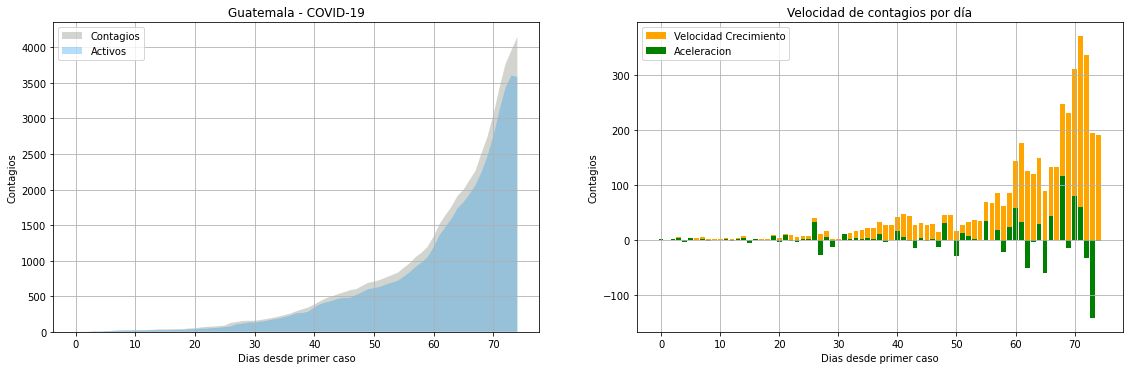

In [44]:
#@titleESTADO ACTUAL
VCH = False #@param {type:"boolean"}
Dias_atras = 15#@param {type:"integer"}
 
import warnings
warnings.filterwarnings("ignore")
fig,(axs,axs2) = plt.subplots(1,2)
plt.subplots_adjust(top=1.2, wspace=.2,right=2.6)
 
#CONTAGIOS & ACTIVOS
axs.set_title("{} - COVID-19".format(pais))
axs.set_ylabel('Contagios')
axs.set_xlabel('Dias desde primer caso')
axs.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
axs.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
axs.legend(loc='upper left')
axs.grid()
 
#VELOCIDAD DE CRECIMIENTO
horas= 1 if (VCH) else 24
texto_vel = "hora" if (VCH) else "día"
velocidad,aceleracion,indice_crecimiento,indice_activos=vel_crecimiento(horas)
axs2.set_title("Velocidad de contagios por {}".format(texto_vel) )
axs2.set_xlabel('Dias desde primer caso')
axs2.set_ylabel('Contagios')
axs2.bar(x.flatten(),velocidad.flatten(),label="Velocidad Crecimiento",color="Orange" )
axs2.bar(x.flatten(),aceleracion.flatten(),label="Aceleracion",color="Green" )
axs2.legend(loc='upper left')
axs2.grid()
#fig.legend()
fig.show()
 
#METRICAS
#media_vc=7
print("DIA:{} \nVELOCIDAD CRECIMIENTO: ACTUAL[{:,.0f}] || MAX[{:,.0f}] || HACE {} DIAS[{:,.0f}] || INCREMENTO[{:,.0f}] || INCREMENTO_MEDIA[{:,.0f}] \nCONTAGIOS: {:,.0f} [{:,.0f}] || ICD{} \nACTIVOS: {:,.0f} [{:,.0f}] || ICD{} \nRECUPERADOS:{:,.0f} || [{:,.2f}%] \nFALLECIDOS: {:,.0f} || [{:,.2f}%]".format(
    x[-1:].flatten(),
    velocidad.flatten()[-1],np.max(velocidad),Dias_atras,velocidad.flatten()[-Dias_atras-1],np.sum(aceleracion[-Dias_atras:]),np.mean(aceleracion[-Dias_atras:]),
    y[-1],y[-1]*np.mean(indice_crecimiento[-Dias_atras:]),np.round(indice_crecimiento[-1:].flatten(),decimals=4),
    activos[-1],activos[-1]*np.mean(indice_activos[-Dias_atras:]),np.round(indice_activos[-1].flatten(),decimals=4),
    recuperados[-1],recuperados[-1]/y[-1]*100,
    muertes[-1],muertes[-1]/y[-1]*100) )

# **MODELO**

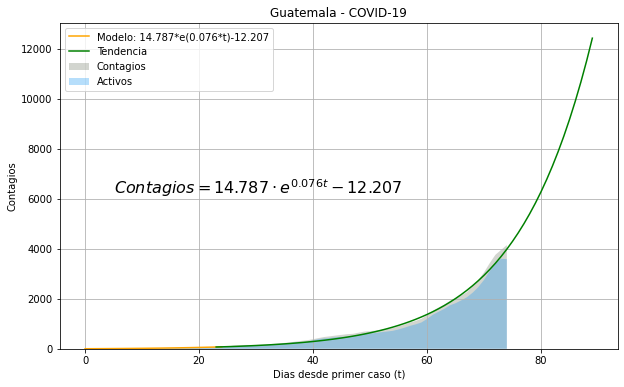

[ 3984.  4298.  4636.  5002.  5396.  5821.  6280.  6774.  7307.  7883.
  8503.  9173.  9895. 10673. 11513. 12419.]


In [64]:
#@title
fecha_ini = "2020-03-14" #@param {type:"date"}
fecha_fin = "2020-04-07" #@param {type:"date"}
 
Activos = False #@param {type:"boolean"}
Exponencial = True #@param {type:"boolean"}
Grado_polinomio =  3#@param {type:"integer"}
dias_pred =  15#@param {type:"integer"}
Actualizar_BigQuery = False #@param {type:"boolean"}
 
#dias_pred= 15
 
#TRAINNING & TEST 
cond_train,cond_test=dataset.loc[(dataset['date'] >= fecha_ini) & (dataset['date'] <= fecha_fin)],dataset.where(dataset["date"]>=fecha_fin).dropna()
#cond_train,cond_test = dataset.where(dataset["date"]<fecha_fin).dropna(),dataset.where(dataset["date"]>=fecha_fin).dropna()
 
campo = 5 if (Activos) else 2
x_train,y_train = cond_train.index.values.reshape(-1,1),cond_train.iloc[:, campo].values
x_test,y_test = cond_test.index.values.reshape(-1,1),cond_test.iloc[:, campo].values
 
#MODELO EXPONENCIAL 
if (Exponencial):
  y_pred,tend,coef=exponential_regression(x_train, y_train,dias_pred)
else:
  #MODELO POLINOMIO GRADO N
  from sklearn import linear_model
  from sklearn.preprocessing import PolynomialFeatures
  polinomio = PolynomialFeatures(degree = Grado_polinomio)
  x_modelo = polinomio.fit_transform(x_train)
 
  #MODELO
  modelo = linear_model.LinearRegression()
  modelo.fit(x_modelo,y_train)
  y_modelo = modelo.predict(x_modelo)
 
  #TEST MODELO
  from datetime import date
  today = date.today()
  dif_y,y_pred_test,prediccion_semana = [],[],[]
  fecha_hoy = format(today.year)+"-"+format(today.month).zfill(2)+"-"+format(today.day).zfill(2)
  if fecha_fin<fecha_hoy:
    y_pred_test = modelo.predict(polinomio.fit_transform(x_test))
    dif_y = pd.DataFrame(np.round(y_pred_test, decimals=0),y_test)
  #print(dif_y)
 
  #METRICAS
  from sklearn.metrics import mean_squared_error
  print("R²(modelo): "+str(round(modelo.score(x_modelo,y_train),4)))
  print("MSE: "+str(round(math.sqrt(mean_squared_error(y_pred_test, y_test)),4)))
  print('COEFICIENTES MODELO: '+ str(modelo.coef_) + "\n")
 
  #TENDENCIA 
  x_semana = np.array(dias_predecir(dias_pred+1))
  prediccion_semana = modelo.predict(polinomio.fit_transform(x_semana.reshape(-1,1)))
  print(np.round(prediccion_semana,decimals=0))
  
  #GRAFICA
  plt.figure(figsize=[10,6])
  plt.title(pais + " - COVID-19")
  plt.xlabel('Dias desde primer caso')
  plt.ylabel('Contagios')
  plt.stackplot(x.flatten(),y, labels=["Contagios"], colors="#6C7463", alpha=0.3)
  plt.stackplot(x.flatten(),activos, labels=["Activos"], colors="#0F92F3",alpha=0.3)
  plt.plot(x_train,y_modelo, color = "orange", label = "Modelo")
  plt.plot(x_test,y_pred_test, color = "green")
  plt.plot(x_semana,prediccion_semana, color = "green", label = "Tendencia")
  plt.grid()
  plt.legend(loc='upper left')
 
 
#ACTUALIZAR DATOS BIG QUERY
if (Actualizar_BigQuery) and (Exponencial):
  columnas = ["fecha","pais","confirmados","muertes","recuperados",
              "activos","velocidad","aceleracion","indice_crecimiento","modelo"]
  dfs = [dataset,pd.DataFrame(velocidad),
                pd.DataFrame(aceleracion),
                pd.DataFrame(indice_crecimiento),
                pd.DataFrame(y_pred),
                ]
  df_todo=pd.concat(dfs,axis=1)
  df_todo.columns=columnas
  tendencia=pd.DataFrame(tend[1:])
  tendencia.columns=["modelo"]
  df_todo=df_todo.append(tendencia)
  df_todo=df_todo.reset_index()
  df_todo["dias"] = df_todo.index.values
  tabla = 'dataset.covid19_gt'
  df_todo.to_gbq(tabla,project_id=project_id,if_exists='replace')
 
  #COEFICIENTES
  coeficientes = pd.DataFrame(np.round(coef,decimals=3))
  coeficientes.columns=["coeficientes"]
  coeficientes["index"] = coeficientes.index.values
  tabla_coef = 'dataset.coef_funcion'
  coeficientes.to_gbq(tabla_coef,project_id=project_id,if_exists='replace')
 
elif (Actualizar_BigQuery):
  print("WARNING: Solo se puede actuliza datos del modelo Exponencial")

# **MODELO SIR**

R0 = 2.1399999999999997


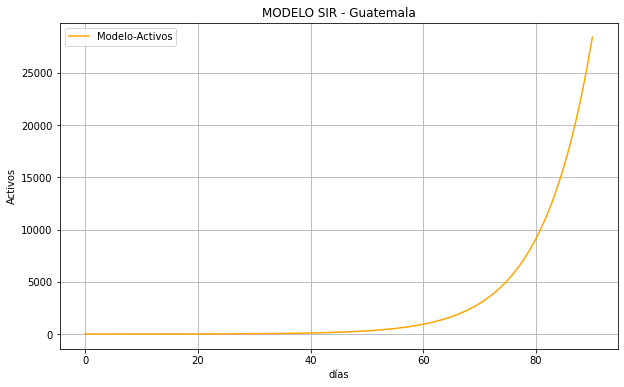

In [61]:
#@title
Poblacion =  16e6#@param {type:"number"}
beta =  .214#@param {type:"number"}
gamma =  0.1#@param {type:"number"}
tiempo =   90#@param {type:"number"}
modelo_completo = False #@param {type:"boolean"}
datos_pais = False #@param {type:"boolean"}
N=Poblacion

#VALORES INICIALES
I0,R0 = 1,0
S0 = N - I0 - R0
Ro = (beta)/(gamma)
print('R0 =',Ro)

#GRAFICA
plt.figure(figsize=[10,6])

if (modelo_completo):
  t = np.linspace(0,tiempo ,tiempo)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta, gamma))
  plt.ylabel("% Población")
  plt.plot(t, sol_ecuaciones[:, 1]/Poblacion, label="Activos", color="Orange")
  plt.plot(t, sol_ecuaciones[:, 0]/Poblacion, label="Suceptibles", color="Blue")
  plt.plot(t, sol_ecuaciones[:, 2]/Poblacion, label="Recuperados", color="Green") 
else:
  t = np.linspace(0,tiempo ,tiempo)
  sol_ecuaciones = scipy.integrate.odeint(Modelo_SIR, [S0, I0, R0], t, args=(N,beta, gamma)) 
  plt.ylabel("Activos")
  plt.plot(t, sol_ecuaciones[:, 1], label="Modelo-Activos", color="Orange")  
  if (datos_pais):
    plt.bar(x[0:tiempo+1].flatten(),activos[0:tiempo+1].flatten(), color="Blue",alpha=0.3,label="Activos" )
    #plt.plot(t, sol_ecuaciones[:, 2], label="Recuperados", color="Green") 
  

plt.title("MODELO SIR - {}".format(pais))
plt.xlabel("días")
plt.grid()
plt.legend()
plt.show()


## Ecuaciones Diferenciales

---


![texto alternativo](https://media.elmostrador.cl/2020/03/dos.png)

#https://ajph.aphapublications.org/doi/pdf/10.2105/AJPH.2013.301704s
